# Synthetic control with `pymc` models

In [1]:
import arviz as az

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("sc")
treatment_time = 70

## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

### Convex Hull Assumption

The synthetic control method uses non-negative weights that sum to one. This means the synthetic control is a **convex combination** of the control units—it can only produce values within the range spanned by the controls at each time point.

:::{note}
For the method to work well, the treated unit's pre-intervention trajectory should lie within the "envelope" of the control units. If all controls are consistently above or below the treated unit, the method cannot construct an accurate counterfactual.
:::

CausalPy automatically checks this assumption when you create a `SyntheticControl` object and will issue a warning if violated. See the {term}`Convex hull condition` glossary entry and {cite:t}`abadie2010synthetic` for more details. The Augmented Synthetic Control Method {cite:p}`benmichael2021augmented` can handle cases where this assumption is violated.



In [4]:
df.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.0,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.0,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.0,1.232330
3,2.816255,2.424558,0.252894,-1.260527,1.938960,2.088586,-3.563201,1.520801,-0.0,1.672995
4,3.865208,2.358650,0.311572,-2.393438,1.977716,2.752152,-3.515991,1.983661,-0.0,1.775940


In [5]:
result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=["a", "b", "c", "d", "e", "f", "g"],
    treated_units=["actual"],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


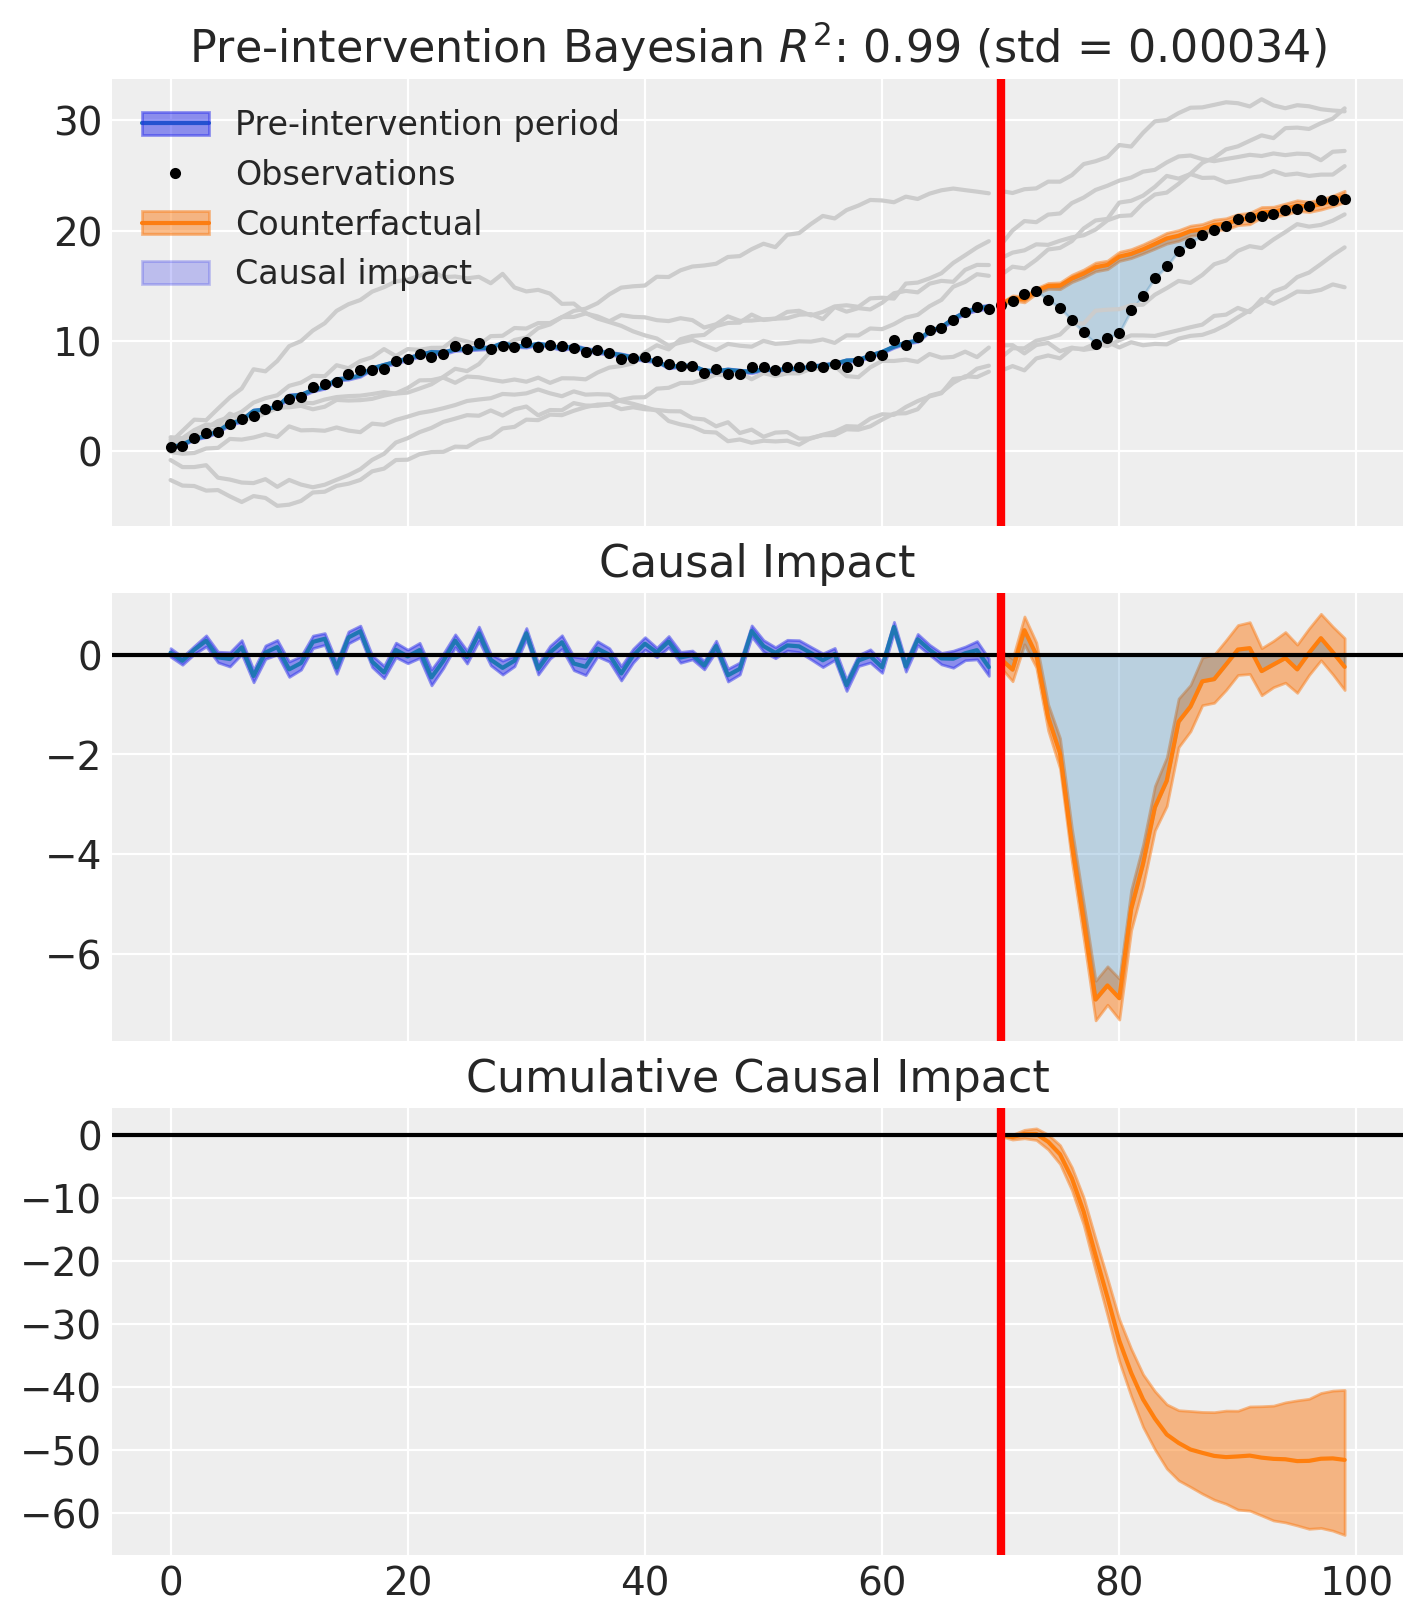

In [6]:
fig, ax = result.plot(plot_predictors=True)

In [7]:
result.summary()

================================SyntheticControl================================
Control units: ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Treated unit: actual
Model coefficients:
    a            0.33, 94% HDI [0.3, 0.38]
    b            0.05, 94% HDI [0.011, 0.089]
    c            0.3, 94% HDI [0.26, 0.35]
    d            0.054, 94% HDI [0.01, 0.1]
    e            0.024, 94% HDI [0.001, 0.065]
    f            0.2, 94% HDI [0.11, 0.26]
    g            0.038, 94% HDI [0.0028, 0.087]
    y_hat_sigma  0.26, 94% HDI [0.22, 0.31]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

In [8]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-1.72,0.212,-2.117,-1.35,0.006,0.004,1152.0,1649.0,1.0


:::{Warning}

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [9]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-51.61,6.35,-63.52,-40.51,0.186,0.105,1152.0,1649.0,1.0


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with average and cumulative effects, HDI intervals, tail probabilities, and relative effects.


In [10]:
# Generate effect summary for the full post-period
stats = result.effect_summary(treated_unit="actual")
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-1.720330,-1.705730,-2.141285,-1.344371,0.0,-9.142522,-11.144332,-7.299538
cumulative,-51.609893,-51.171893,-64.238552,-40.331122,0.0,-9.142522,-11.144332,-7.299538


In [11]:
print(stats.text)

Post-period (70 to 99), the average effect was -1.72 (95% HDI [-2.14, -1.34]), with a posterior probability of an increase of 0.000. The cumulative effect was -51.61 (95% HDI [-64.24, -40.33]); probability of an increase 0.000. Relative to the counterfactual, this equals -9.14% on average (95% HDI [-11.14%, -7.30%]).


You can customize the summary in several ways:

- **Window**: Analyze a specific time period instead of the full post-period
- **Direction**: Specify whether you're testing for an increase, decrease, or two-sided effect
- **Options**: Include/exclude cumulative or relative effects


In [12]:
# Example: Analyze first half of post-period
post_indices = result.datapost.index
window_start = post_indices[0]
window_end = post_indices[len(post_indices) // 2]

stats_windowed = result.effect_summary(
    window=(window_start, window_end),
    treated_unit="actual",
    direction="two-sided",
    cumulative=True,
    relative=True,
)

stats_windowed.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-3.057512,-3.045187,-3.430665,-2.706604,0.0,1.0,-18.635032,-20.456322,-16.867122
cumulative,-48.920194,-48.722991,-54.890645,-43.305657,0.0,1.0,-18.635032,-20.456322,-16.867122


In [13]:
print(stats_windowed.text)

Post-period (70 to 85), the average effect was -3.06 (95% HDI [-3.43, -2.71]), with a posterior probability of an effect of 1.000. The cumulative effect was -48.92 (95% HDI [-54.89, -43.31]); probability of an effect 1.000. Relative to the counterfactual, this equals -18.64% on average (95% HDI [-20.46%, -16.87%]).


## References
:::{bibliography}
:filter: docname in docnames
:::